# Imports

Import libraries

In [ ]:
import torch
import torchvision
import os
import time
import glob
import pickle
import pandas as pd
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Sampler, WeightedRandomSampler
from torchvision import transforms, utils
from PIL import Image
from math import prod
from statistics import mean
from torchvision import transforms
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, hamming_loss, confusion_matrix

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import random
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [ ]:
# Import training functions
from training.datasets import *
from training.model import *
from training.training_utils import *

# GCS Bucket Set up

In [ ]:
project_id = 'responsive-cab-442307-s0'
bucket_name = 'deskbrainsec'

In [ ]:
!gcloud auth login

Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=l6VwyNw19tIyCgmPuMkEceCe1asHHC&prompt=consent&token_usage=remote&access_type=offline&code_challenge=muziLt5cq5ms1suhgMAKWxV2E9VeMm5xtOjFaU2hSsM&code_challenge_method=S256

Once finished, enter the verification code provided in your browser: 4/0AeanS0YuhFkXWD2EASk3l7vsRQP4hT4K5Ljl-HIUdkgFP0f-E81mjc2nl1HAd6K0bT19oQ

You are now logged in as [oshen@ucdavis.edu].
Your current project is [

In [ ]:
!pwd

/content


In [ ]:
!gcloud config set project {project_id}
!gsutil cp gs://{bucket_name}/tiles.zip tiles.zip
!gsutil cp gs://{bucket_name}/wmgm-split.zip wmgm-split.zip
!gsutil cp gs://{bucket_name}/wmgm-small.zip wmgm-small.zip
!gsutil cp gs://{bucket_name}/tiles-small-imabalance.zip tiles-small-imbalance.zip

Updated property [core/project].
Copying gs://deskbrainsec/tiles.zip...
- [1 files][  3.0 GiB/  3.0 GiB]   64.0 MiB/s                                   
Operation completed over 1 objects/3.0 GiB.                                      
Copying gs://deskbrainsec/wmgm-split.zip...
| [1 files][152.0 MiB/152.0 MiB]                                                
Operation completed over 1 objects/152.0 MiB.                                    
Copying gs://deskbrainsec/wmgm-small.zip...
/ [1 files][  2.3 KiB/  2.3 KiB]                                                
Operation completed over 1 objects/2.3 KiB.                                      
Copying gs://deskbrainsec/tiles-small-imabalance.zip...
/ [1 files][  2.4 KiB/  2.4 KiB]                                                
Operation completed over 1 objects/2.4 KiB.                                      


In [ ]:
!unzip -u 'tiles.zip' -d '/content/'
!mv '/content/content/drive/MyDrive/DeskBrainSec/tiles' '/content/'
!rm -r '/content/content'

Streaming output truncated to the last 5000 lines.
  inflating: /content/content/drive/MyDrive/DeskBrainSec/tiles/hold-out/NA4964-02_AB17-24/NA4964-02_AB17-24_10_16.jpg_83.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/tiles/hold-out/NA4964-02_AB17-24/NA4964-02_AB17-24_12_18.jpg_12.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/tiles/hold-out/NA4964-02_AB17-24/NA4964-02_AB17-24_10_16.jpg_101.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/tiles/hold-out/NA4964-02_AB17-24/NA4964-02_AB17-24_12_15.jpg_32.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/tiles/hold-out/NA4964-02_AB17-24/NA4964-02_AB17-24_9_18.jpg_17.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/tiles/hold-out/NA4964-02_AB17-24/NA4964-02_AB17-24_12_17.jpg_73.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/tiles/hold-out/NA4964-02_AB17-24/NA4964-02_AB17-24_10_16.jpg_52.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/til

In [ ]:
!unzip -u 'wmgm-split.zip' -d '/content/'
!mv '/content/content/drive/MyDrive/DeskBrainSec/wmgm-split' '/content/'
!rm -r '/content/content'

Streaming output truncated to the last 5000 lines.
  inflating: /content/content/drive/MyDrive/DeskBrainSec/wmgm-split/train/wm_NA5010-02_AB17-24_13824_24832_14080_25088_97.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/wmgm-split/train/wm_NA4993-02_AB17-24_4352_21504_4608_21760_84.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/wmgm-split/train/bg_NA4626-02_AB_0_27392_256_27648_107.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/wmgm-split/train/bg_NA4691-02_AB_0_11776_256_12032_46.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/wmgm-split/train/gm_NA4972-02_AB17-24_1792_41984_2048_42240_164.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/wmgm-split/train/wm_NA4626-02_AB_3328_23552_3584_23808_92.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/wmgm-split/train/bg_NA5010-02_AB17-24_0_3328_256_3584_13.jpg  
  inflating: /content/content/drive/MyDrive/DeskBrainSec/wmgm-split/train/bg_NA4695-02_AB_25

In [ ]:
!unzip -u 'wmgm-small.zip' -d '/content/'
!unzip -u 'tiles-small-imbalance.zip' -d '/content/'
!mv 'train-small.csv' '/content/wmgm-split/'
!mv 'validation-small.csv' '/content/wmgm-split/'
!mv 'train-small-imbalance.csv' '/content/tiles/'
!mv 'validation-small-imbalance.csv' '/content/tiles/'

Archive:  wmgm-small.zip
Archive:  tiles-small-imbalance.zip


# Google Drive Set up

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Change environment directory to DeskBrainSec folder in Google Drive. This is for persistent file storage.

In [ ]:
%cd '/content/drive/MyDrive/DeskBrainSec/'

/content/drive/MyDrive/DeskBrainSec


Unzip datasets into local VM.

In [ ]:
!unzip -u 'tiles.zip' -d '/content/'
!mv '/content/content/drive/MyDrive/DeskBrainSec/tiles' '/content/'
!rm -r '/content/content'

In [ ]:
!unzip -u 'wmgm-split.zip' -d '/content/'
!mv '/content/content/drive/MyDrive/DeskBrainSec/wmgm-split' '/content/'
!rm -r '/content/content'

In [ ]:
!cp '/content/drive/MyDrive/DeskBrainSec/tiles/train-small-imbalance.csv' '/content/tiles/'
!cp '/content/drive/MyDrive/DeskBrainSec/tiles/validation-small-imbalance.csv' '/content/tiles/'
!cp '/content/drive/MyDrive/DeskBrainSec/wmgm-split/train-small.csv' '/content/wmgm-split/'
!cp '/content/drive/MyDrive/DeskBrainSec/wmgm-split/validation-small.csv' '/content/wmgm-split/'

# Exploratory Data Analysis

In [ ]:
import pandas as pd
import seaborn as sns
from IPython.display import display

In [ ]:
val_labels = pd.read_csv('/content/drive/MyDrive/DeskBrainSec/tiles/validation.csv')
print(val_labels.shape)
holdout_labels = pd.read_csv('/content/drive/MyDrive/DeskBrainSec/tiles/hold-out.csv')
print(holdout_labels.shape)

(8630, 8)
(10873, 8)


In [ ]:
train_labels = pd.read_csv('/content/drive/MyDrive/DeskBrainSec/tiles/train.csv')
print(train_labels.shape)
diffuse = train_labels[(train_labels['diffuse'] > 0.99)]
#display(diffuse)
train_labels.describe()

(61370, 8)


,id,cored,diffuse,CAA,negative,flag,notsure
count,61370.000000,61370.000000,61370.000000,61370.000000,61370.000000,61370.000000,61370.000000
mean,22612.677905,0.044859,1.395635,0.058510,0.258172,0.325193,0.035641
std,17323.789819,0.224492,1.065357,0.316624,0.616488,0.723491,0.192772
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6768.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,19987.500000,0.000000,1.006061,0.000000,0.000000,0.000000,0.000000
75%,37800.750000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
max,55465.000000,4.000000,7.827462,5.000000,8.454377,7.532784,3.007697


In [ ]:
total = val_labels.shape[0] + holdout_labels.shape[0] + train_labels.shape[0]
print(f"train split: {train_labels.shape[0] / total}")
print(f"val split: {val_labels.shape[0] / total}")
print(f"hold-out split: {holdout_labels.shape[0] / total}")

train split: 0.7588441136102284
val split: 0.10671052143484229
hold-out split: 0.13444536495492934


<Axes: xlabel='diffuse', ylabel='Count'>

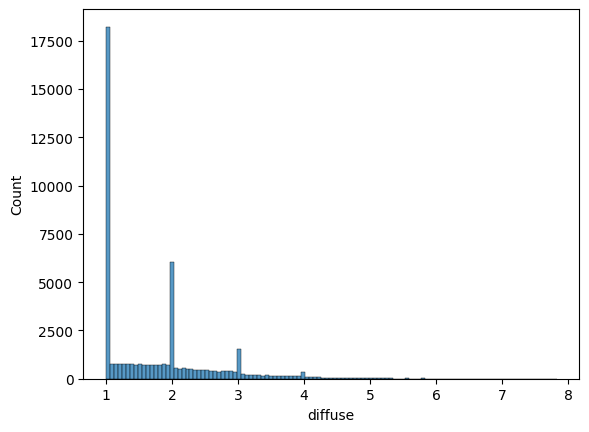

In [ ]:
sns.histplot(diffuse['diffuse'])

(6000, 2)


,filename,label
400,wm_NA4626-02_AB_1536_22784_1792_23040_89.jpg,1
401,wm_NA4626-02_AB_1536_23040_1792_23296_90.jpg,1
402,wm_NA4626-02_AB_1792_23040_2048_23296_90.jpg,1
403,wm_NA4626-02_AB_1792_22784_2048_23040_89.jpg,1
404,wm_NA4626-02_AB_1792_23296_2048_23552_91.jpg,1
...,...,...
5995,wm_NA5015-02_AB17-24_4352_46336_4608_46592_181...,1
5996,wm_NA5015-02_AB17-24_4352_46592_4608_46848_182...,1
5997,wm_NA5015-02_AB17-24_4352_42240_4608_42496_165...,1
5998,wm_NA5015-02_AB17-24_4352_42496_4608_42752_166...,1


<Axes: xlabel='label', ylabel='Count'>

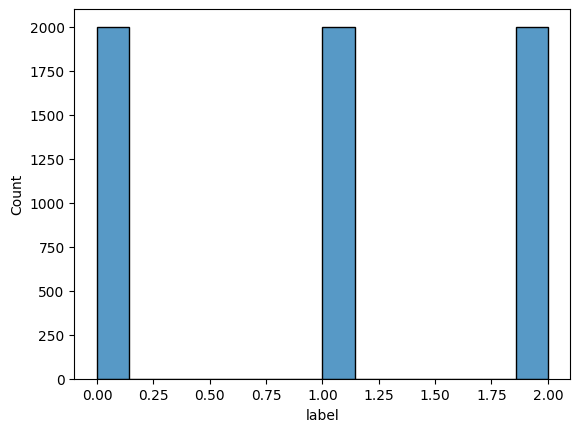

In [ ]:
import pandas as pd
import seaborn as sns
from IPython.display import display

train_labels = pd.read_csv('/content/drive/MyDrive/DeskBrainSec/wmgm/test.csv')
print(train_labels.shape)
display(train_labels[train_labels['label'] == 1])
sns.histplot(train_labels['label'])

Create small version of dataset CSV for debugging:

In [ ]:
plaque_labels = pd.read_csv('/content/drive/MyDrive/DeskBrainSec/tiles/hold-out.csv')
diffuse = plaque_labels[plaque_labels['diffuse'] > 0.99]
caa = plaque_labels[plaque_labels['CAA'] > 0.99]
cored = plaque_labels[plaque_labels['cored'] > 0.99]
positive_indices = (diffuse.index.union(caa.index)).union(cored.index)
negative = plaque_labels.iloc[plaque_labels.index.difference(positive_indices)]
#sample_indices = ((diffuse.head(5).index.union(caa.head(5).index)).union(cored.head(5).index)).union(negative.head(5).index)
#plaque_labels.iloc[sample_indices].to_csv('/content/drive/MyDrive/DeskBrainSec/tiles/validation-small.csv')

In [ ]:
tissue_labels = pd.read_csv('/content/drive/MyDrive/DeskBrainSec/wmgm-split/validation.csv')
bg = tissue_labels[tissue_labels['label'] == 0]
wm = tissue_labels[tissue_labels['label'] == 1]
gm = tissue_labels[tissue_labels['label'] == 2]
sample_indices = (bg.head(5).index.union(wm.head(5).index)).union(gm.head(5).index)
tissue_labels.iloc[sample_indices].to_csv('/content/drive/MyDrive/DeskBrainSec/wmgm-split/validation-small.csv')

# Run Training

## Parameters

In [ ]:
BATCH_SIZE = 128
WORKERS = 2
LR = 0.001
BASE_DIR = '/content/'
EPOCHS = 10
DEBUG = False
USE_CHECKPOINT = False

## Datasets

In [ ]:
from torchvision import transforms

plaque_transform = transforms.Compose([
    transforms.Resize((256, 256)),

    transforms.RandomHorizontalFlip(0.1),
    transforms.RandomVerticalFlip(0.1),
    transforms.RandomRotation(15),

    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),

    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

wmgm_transform = transforms.Compose([
    transforms.Resize((256, 256)),

    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),

    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),

    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),

    # Normalize for pretrained weights
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),

    # Normalize for pretrained weights
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

In [ ]:
plaque_dir = "/content/tiles"
wmgm_dir = "/content/wmgm-split"

if DEBUG:
    plaque_train_set= PlaqueDataset(os.path.join(plaque_dir, 'train-small-imbalance.csv'), os.path.join(plaque_dir, 'train'), transform=plaque_transform)
    plaque_val_set= PlaqueDataset(os.path.join(plaque_dir, 'validation-small-imbalance.csv'), os.path.join(plaque_dir, 'validation'), transform=test_transform)
    wmgm_train_set= WMGMDataset(os.path.join(wmgm_dir, 'train-small.csv'), os.path.join(wmgm_dir, 'train'), transform=wmgm_transform)
    wmgm_val_set= WMGMDataset(os.path.join(wmgm_dir, 'validation-small.csv'), os.path.join(wmgm_dir, 'validation'), transform=test_transform)
else:
    plaque_train_set= PlaqueDataset(os.path.join(plaque_dir, 'train.csv'), os.path.join(plaque_dir, 'train'), transform=plaque_transform)
    plaque_val_set= PlaqueDataset(os.path.join(plaque_dir, 'validation.csv'), os.path.join(plaque_dir, 'validation'), transform=test_transform)
    wmgm_train_set= WMGMDataset(os.path.join(wmgm_dir, 'train.csv'), os.path.join(wmgm_dir, 'train'), transform=wmgm_transform)
    wmgm_val_set= WMGMDataset(os.path.join(wmgm_dir, 'validation.csv'), os.path.join(wmgm_dir, 'validation'), transform=test_transform)


In [ ]:
print(len(wmgm_train_set))
print(len(plaque_train_set))

# Plaque has multiple labels (cored, diffuse, etc), want to balance them
# wmgm has only one label but few datapoints, want to do more transforms to it

print(wmgm_train_set[0])
print(plaque_train_set[0])
"""
s = set()
for i in range(1000):
  s.add(tuple(plaque_train_set[i][1].tolist()))
  if i % 100 == 99:
    print(i)


print(s)
"""

print(plaque_train_set.labels)
np.where(plaque_train_set.labels[:, 0] == 1)[0].shape

4500
61370
(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-1.2274, -0.6965,  0.5536,  ..., -2.1179, -2.1179, -2.1179],
         [-1.4158, -1.0390,  0.0398,  ..., -2.1179, -2.1179, -2.1179],
         [-1.5185, -1.1932, -0.2171,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-1.1253, -0.5826,  0.6779,  ..., -2.0357, -2.0357, -2.0357],
         [-1.3179, -0.9328,  0.1527,  ..., -2.0357, -2.0357, -2.0357],
         [-1.4230, -1.0903, -0.0924,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.80

(2141,)

## Dataloaders

In [ ]:
# Define a sampler for plaque dataset to oversample minority classes
class_sample_count = np.array(
    [len(np.where(plaque_train_set.labels[:, t] == 1)[0]) for t in range(3)])

print([len(np.where(plaque_train_set.labels[:, t] == 1)[0]) for t in range(3)])
print(class_sample_count)
weight = 1. / class_sample_count
weight /= np.linalg.norm(weight)
print(weight)
samples_weight = np.array([max(weight * t) for t in plaque_train_set.labels.numpy()])
print(len(samples_weight), samples_weight)
samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

[4, 81, 3]
[ 4 81  3]
[0.5997368  0.02961663 0.79964907]
100 [0.5997368  0.5997368  0.5997368  0.5997368  0.79964907 0.79964907
 0.79964907 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663
 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663
 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663
 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663
 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663
 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663
 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663
 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663
 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663
 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663
 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663
 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663
 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663 0.02961663
 

In [ ]:
plaque_train_loader = DataLoader(plaque_train_set, batch_size=BATCH_SIZE, sampler=sampler, shuffle=False, num_workers=WORKERS)
plaque_val_loader = DataLoader(plaque_val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)
wmgm_train_loader = DataLoader(wmgm_train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
wmgm_val_loader = DataLoader(wmgm_val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

In [ ]:
len(plaque_train_loader)

1

### Show augmentations on images in dataloader

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_batch(data_loader, freq=True):
    x, y = next(iter(data_loader))  # Take one batch
    if freq:
      print([len(np.where(y[:, t] == 1)[0]) for t in range(3)])
    print(y.shape)
    print(y)
    print(np.unique(y))
    batch_size = x.size(0)
    grid_size = int(batch_size ** 0.5)
    if grid_size ** 2 < batch_size:
        grid_size += 1

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

    axes = np.ravel(axes)
    print(x[0].shape)

    for i, ax in enumerate(axes):
        if i < batch_size:
            image = x[i].numpy()
            image_min = image.min()
            image_max = image.max()
            image = (image - image_min) / (image_max - image_min)
            image = image.transpose(1, 2, 0)
            ax.imshow(image, cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')

    plt.show()

Show Plaque Batch

[9, 8, 8]
torch.Size([20, 3])
tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 1.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 1.],
        [1., 0., 0.],
        [0., 1., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 1.],
        [0., 1., 1.],
        [0., 0., 1.]])
[0. 1.]
torch.Size([3, 256, 256])


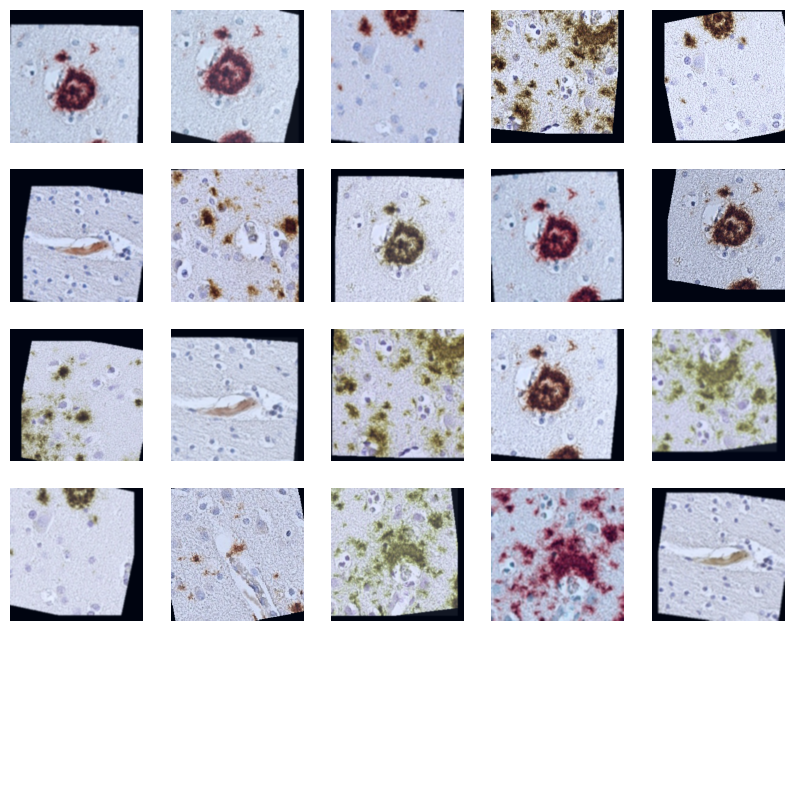

In [ ]:
show_batch(plaque_train_loader)

Show WM/GM Batch

torch.Size([20])
tensor([2, 1, 0, 2, 2, 1, 0, 2, 0, 0, 0, 0, 2, 2, 1, 2, 1, 0, 2, 2])
[0 1 2]
torch.Size([3, 256, 256])


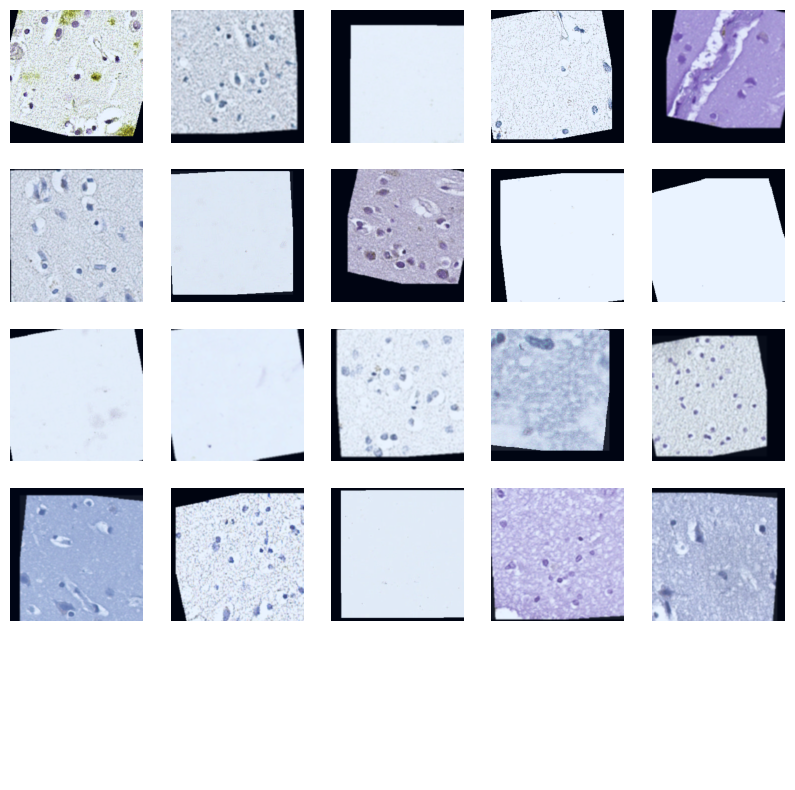

In [ ]:
show_batch(wmgm_train_loader, freq=False)

## Run Full Training

Epoch Number 0
Epoch time: 5.782310485839844
----------------------------------------
Validation Tissue Dataset:
Accuracy =  0.6666666666666666
Balanced Accuracy =  0.75
Micro F1 =  0.6666666666666666
----------------------------------------
Train Tissue Dataset:
Accuracy =  0.64
Balanced Accuracy =  0.764720374476472
Micro F1 =  0.64
----------------------------------------
Validation Plaque Dataset:
Sample-wise Accuracy =  0.35
Balanced Accuracy =  0.25
Sample F1 =  0.0
----------------------------------------
Train Plaque Dataset:
Sample-wise Accuracy =  0.7
Balanced Accuracy =  1.0
Sample F1 =  0.5366666666666666
Model checkpoint saved.


Epoch Number 1
Epoch time: 4.564937353134155
----------------------------------------
Validation Tissue Dataset:
Accuracy =  0.6666666666666666
Balanced Accuracy =  0.75
Micro F1 =  0.6666666666666666
----------------------------------------
Train Tissue Dataset:
Accuracy =  0.68
Balanced Accuracy =  0.7926267281105991
Micro F1 =  0.68
-----------

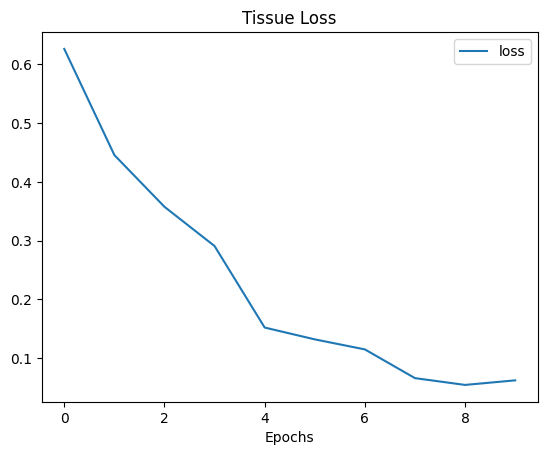

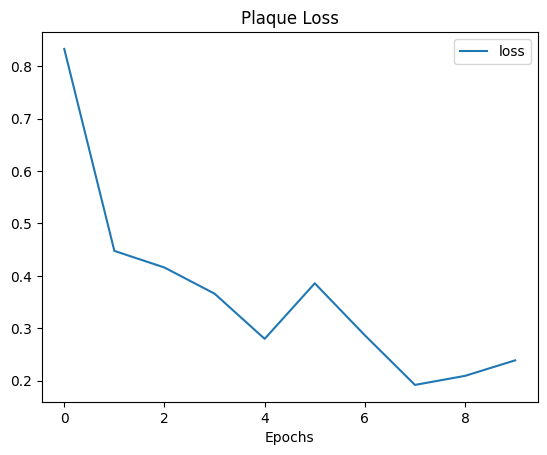

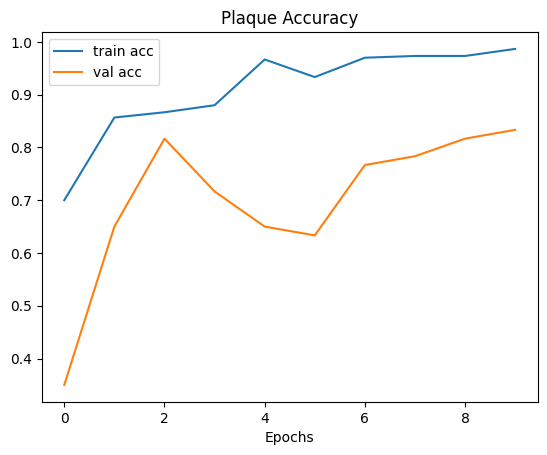

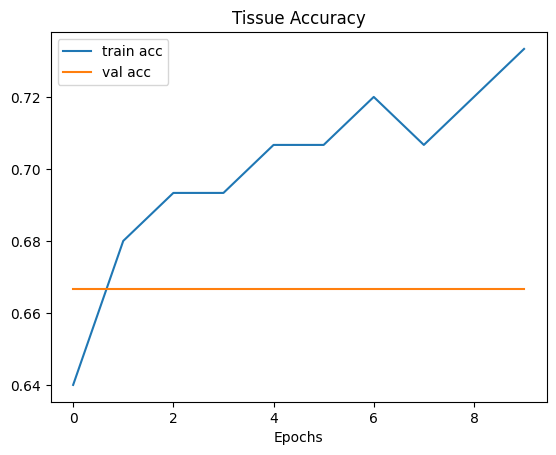

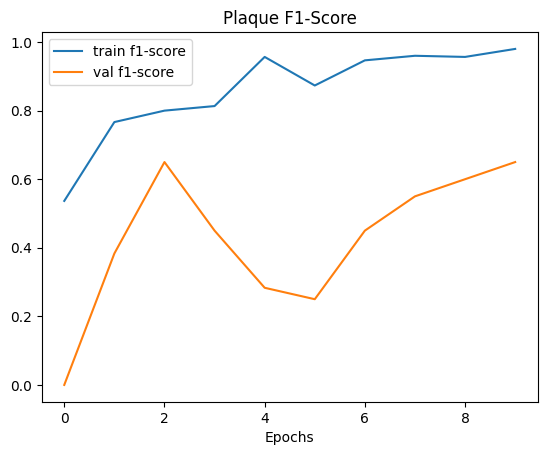

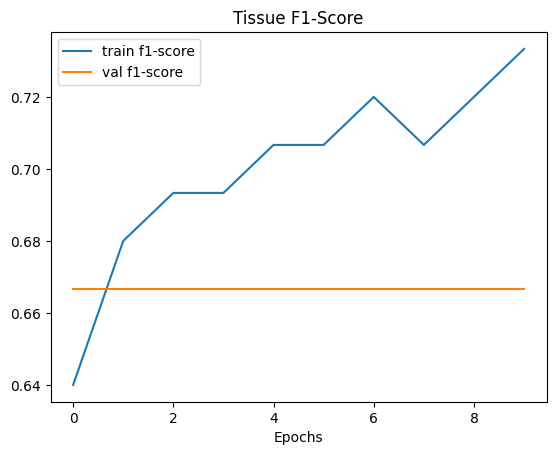

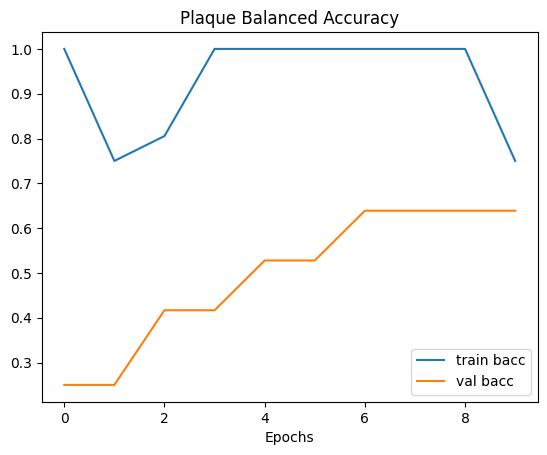

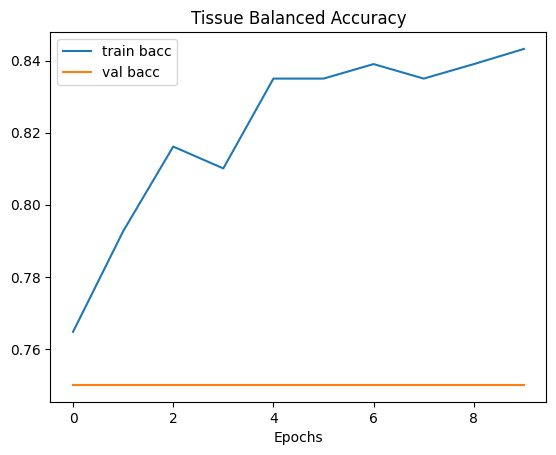

In [ ]:
model = PlaqueTissueClassifier()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=LR/EPOCHS)

if DEBUG:
    model_name = "PlaqueTissueClassifierDebug"
else:
    model_name = "PlaqueTissueClassifier"

loss, acc_train, acc_val, model_score = fit(model_name, model, optimizer, plaque_train_loader,
                                        plaque_val_loader, wmgm_train_loader, wmgm_val_loader,
                                        EPOCHS, BASE_DIR, USE_CHECKPOINT, scheduler=scheduler)

In [ ]:
print(model_score)

0.47916666666666663


# Inference

In [ ]:
def get_class_cm(labels_list, preds_list):
    class_cm = []
    for i in range(len(labels_list[0])):
        class_labels = [l[i] for l in labels_list]
        class_preds = [p[i] for p in preds_list]
        class_cm.append(confusion_matrix(class_labels, class_preds))
    return class_cm

In [ ]:
def test_holdout(model, plaque_holdout_loader, tissue_holdout_loader, base_dir):
    f1_holdout, acc_holdout, bacc_holdout = dict(), dict(), dict()
    holdout_metrics = eval_step(model, plaque_holdout_loader, tissue_holdout_loader, 'cpu')
    holdout_predictions = holdout_metrics[0]
    holdout_labels = holdout_metrics[1]

    # Save tissue validation metrics
    t_holdout_metrics = calc_tissue_metrics(holdout_predictions["tissue"], holdout_labels["tissue"], set_name='Holdout')
    f1_holdout["tissue"] = t_holdout_metrics[0]
    acc_holdout["tissue"] = t_holdout_metrics[1]
    bacc_holdout["tissue"] = t_holdout_metrics[2]

    # Save plaque validation metrics
    p_holdout_metrics = calc_plaque_metrics(holdout_predictions["plaque"], holdout_labels["plaque"], set_name='Holdout')
    f1_holdout["plaque"] = p_holdout_metrics[0]
    acc_holdout["plaque"] = p_holdout_metrics[1]
    bacc_holdout["plaque"] = p_holdout_metrics[2]
    #print("f1 per class:", f1_score(holdout_labels["plaque"], holdout_predictions["plaque"], average=None))
    plaque_cm = get_class_cm(holdout_labels["plaque"], holdout_predictions["plaque"])

    return f1_holdout, acc_holdout, bacc_holdout, plaque_cm


In [ ]:
BASE_DIR = '/content/drive/MyDrive/DeskBrainSec'
BATCH_SIZE = 128

Load model with weights from training. Kaggle models are trained on 2x T4 GPUs. We need to convert to CPU model and remove `module.` prefix added from DataParallel wrapper.

In [ ]:
test_checkpoint = '/content/checkpoints/PlaqueTissueClassifier_Epoch_0.pth'

In [ ]:
model = PlaqueTissueClassifier().to('cpu')
checkpoint_path = os.path.join(BASE_DIR, test_checkpoint)
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

new_state_dict = dict()
for k, v in checkpoint['model_state_dict'].items():
    name = k.replace('module.', '') # remove `module.`
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [ ]:
plaque_dir = "/content/tiles"
wmgm_dir = "/content/wmgm-split"

plaque_holdout_set = PlaqueDataset(os.path.join(plaque_dir, 'hold-out.csv'), os.path.join(plaque_dir, 'hold-out'), transform=test_transform)
wmgm_holdout_set= WMGMDataset(os.path.join(wmgm_dir, 'hold-out.csv'), os.path.join(wmgm_dir, 'hold-out'), transform=test_transform)

plaque_holdout_loader = DataLoader(plaque_holdout_set, batch_size=BATCH_SIZE, shuffle=False)
wmgm_holdout_loader = DataLoader(wmgm_holdout_set, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
f1, acc, bacc, class_cm = test_holdout(model, plaque_holdout_loader, wmgm_holdout_loader, BASE_DIR)

----------------------------------------
Holdout Tissue Dataset:
Accuracy =  0.953030303030303
Balanced Accuracy =  0.9580941567316387
Micro F1 =  0.953030303030303
----------------------------------------
Holdout Plaque Dataset:
Sample-wise Accuracy =  0.9677795150065912
Balanced Accuracy =  1.0
Sample F1 =  0.9310524540911738


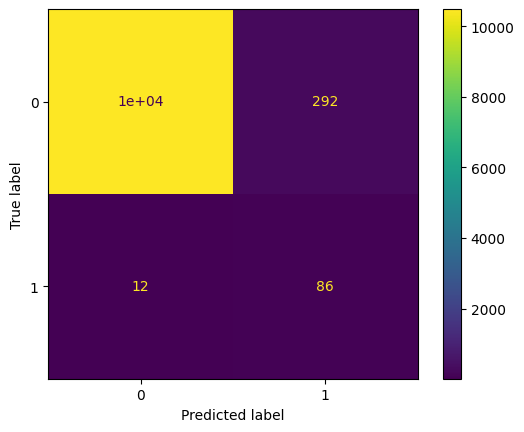

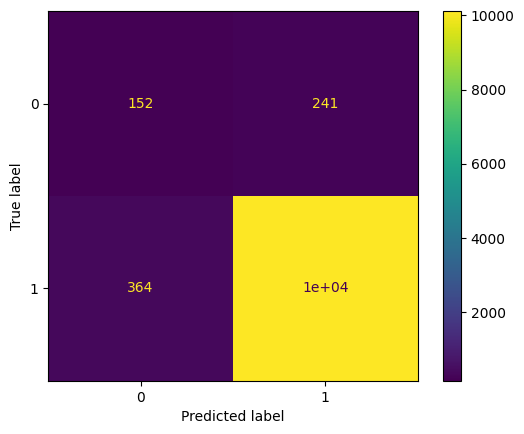

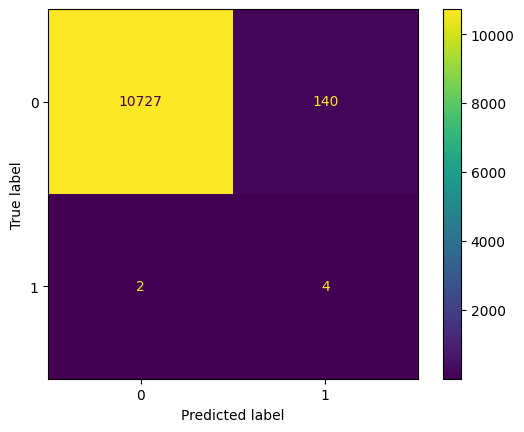

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
for cm in class_cm:
    ConfusionMatrixDisplay(cm).plot()

In [ ]:
model_debug = PlaqueTissueClassifier().to('cpu')
checkpoint_path = os.path.join(BASE_DIR, 'checkpoints/PlaqueTissueClassifierDebug_Epoch_7.pth')
checkpoint = torch.load(checkpoint_path)
model_debug.load_state_dict(checkpoint['model_state_dict'])
f1_debug, acc_debug, bacc_debug = test_holdout(model_debug, plaque_holdout_loader, wmgm_holdout_loader, BASE_DIR)

----------------------------------------
Holdout Tissue Dataset:
Accuracy =  0.7848484848484848
Balanced Accuracy =  0.8381240915214834
Micro F1 =  0.7848484848484848
----------------------------------------
Holdout Plaque Dataset:
Sample-wise Accuracy =  0.7554799350072043
Balanced Accuracy =  1.0
Sample F1 =  0.6213556516140899


In [ ]:
# 0: cored, 1: diffuse, 2: CAA
def count_classes(dataset):
    counts = np.array([len(np.where(dataset.labels[:, t] == 1)[0]) for t in range(3)])
    return counts

In [ ]:
print(count_classes(plaque_holdout_set))
print(count_classes(plaque_train_set))
print(count_classes(plaque_val_set))

[   98 10480     6]
[ 2141 48123  2227]
[ 381 7487  126]
